In [106]:
## which state has the most sightings? over time?
## most frequent shape by state?
## timeline changes? trends?
## sighting density around airports/afb

In [107]:
import os
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [108]:
ufo_df = pd.read_csv('resources/ufo.csv', low_memory=False)

In [109]:
nRow, nCol = ufo_df.shape
print(f'This csv has {nRow} rows and {nCol} columns')

This csv has 80332 rows and 11 columns


In [110]:
#split datetime into date and time and move them to the front of the df

ufo_df[['date', 'time']] = ufo_df.datetime.str.split(' ', expand=True)

first_column = ufo_df.pop('time')
ufo_df.insert(0, 'time', first_column)

first_column = ufo_df.pop('date')
ufo_df.insert(0, 'date', first_column)

ufo_df.pop('datetime')

ufo_df.head()

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949,20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949,21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955,17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956,21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960,20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [111]:
ufo_df['datetime64'] = pd.to_datetime(ufo_df.date, infer_datetime_format = True)
display(ufo_df.head())

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,datetime64
0,10/10/1949,20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949-10-10
1,10/10/1949,21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949-10-10
2,10/10/1955,17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955-10-10
3,10/10/1956,21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956-10-10
4,10/10/1960,20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960-10-10


In [112]:
#convert 'duration' column from object to float64

ufo_df.rename(columns = {'duration (seconds)':'duration_sec'}, inplace = True)

ufo_df["duration_sec"] = pd.to_numeric(ufo_df.duration_sec, errors='coerce')

In [113]:
ufo_df.dtypes

date                            object
time                            object
city                            object
state                           object
country                         object
shape                           object
duration_sec                   float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                        object
longitude                      float64
datetime64              datetime64[ns]
dtype: object

In [114]:
ufo_df['shape'].value_counts()

light        16565
triangle      7865
circle        7608
fireball      6208
other         5649
unknown       5584
sphere        5387
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1962
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
delta            7
round            2
crescent         2
pyramid          1
flare            1
hexagon          1
dome             1
changed          1
Name: shape, dtype: int64

In [115]:
ufo_df['shape'] = ufo_df['shape'].replace(
    {'unknown': 'other', 'changed': 'changing', 'flare': 'fireball', 'delta': 'triangle', 'sphere': 'round', 'circle': 'round'})

In [116]:
ufo_df['shape'].value_counts()

light        16565
round        12997
other        11233
triangle      7872
fireball      6209
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1963
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
crescent         2
pyramid          1
hexagon          1
dome             1
Name: shape, dtype: int64

In [117]:
ufo_df['shape'].value_counts()

light        16565
round        12997
other        11233
triangle      7872
fireball      6209
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1963
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
crescent         2
pyramid          1
hexagon          1
dome             1
Name: shape, dtype: int64

In [121]:
state_shape = ufo_df.groupby(['state', 'shape']).size().reset_index(name='count')
state_shape.head()

,state,shape,count
0,ab,changing,4
1,ab,chevron,2
2,ab,cigar,10
3,ab,cone,4
4,ab,cross,1


In [134]:
max_shapes = state_shape.groupby('state')['shape'].max()
max_shapes

state
ab    triangle
ak    triangle
al    triangle
ar    triangle
az    triangle
        ...   
wi    triangle
wv    triangle
wy    triangle
yk    teardrop
yt    triangle
Name: shape, Length: 67, dtype: object

<AxesSubplot:xlabel='state,shape'>

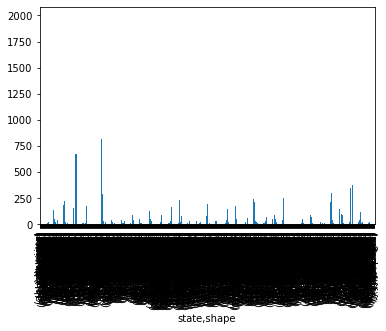

In [56]:
state_shape = ufo_df.groupby(['state', 'shape']).size().reset_index(name='count')
state_shape.head()

,state,shape,count
0,ab,changing,4
1,ab,chevron,2
2,ab,cigar,10
3,ab,circle,29
4,ab,cone,4


In [118]:
ufo_df.loc['state']

KeyError: 'state'

In [95]:
state_shape.set_index('state', inplace=True)
state_shape.groupby('shape')['count'].plot(legend=True)

KeyError: "None of ['state'] are in the columns"

<AxesSubplot:xlabel='state'>

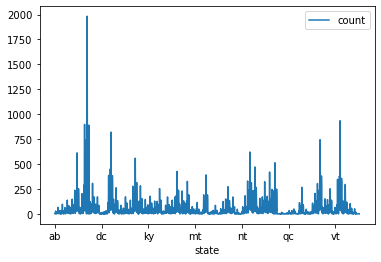

In [63]:
state_shape.plot(kind="line")